In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import dlib
import cv2
import os
%matplotlib inline

In [2]:
X = []
Y = []
path_of_dataset = 'D:\mtech\\implementation\hindi_3_word_dataset'
path_of_shape_predictor = 'D:\\mtech\\implementation\\dlib_model\\shape_predictor_68_face_landmarks_GTX.dat'

predictor = dlib.shape_predictor(path_of_shape_predictor)
detector = dlib.get_frontal_face_detector()
window_size = 30
for folder in os.listdir(path_of_dataset):
    for video in os.listdir(os.path.join(path_of_dataset,folder)):
        Y.append(folder)
        cap = cv2.VideoCapture(os.path.join(path_of_dataset,folder,video))
        video_frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames_window = max(int(video_frames_count/window_size), 1)
        window = []
        for k in range(window_size):         
            cap.set(cv2.CAP_PROP_POS_FRAMES, k * skip_frames_window)
            ret,frame = cap.read()
            if not ret:
                break
            resized = cv2.resize(frame,(256,512))
            gray = cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
            results = detector(gray)
            for face in results:
                landmarks = predictor(gray, face)
                lips_points = []
                for i in range(48, 68):  
                    x, y = landmarks.part(i).x, landmarks.part(i).y
                    lips_points.append((x, y))
                x, y, w, h = cv2.boundingRect(np.array(lips_points))
                cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cropped = resized[y:y+h,x:x+w]
                window.append(cv2.resize(cropped,(128,64)))
            if cv2.waitKey(100)&0XFF==ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()   
        X.append(window)            


In [3]:
X = np.array(X)
X.shape

(8, 30, 64, 128, 3)

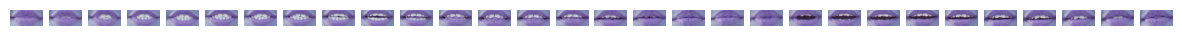

In [4]:
fig, axs = plt.subplots(1, len(X[0]), figsize=(15, 10))
i = 0
for img in X[0]:
    axs[i].imshow(img)
    axs[i].axis('off')
    i=i+1

plt.show()

In [5]:
Y = pd.get_dummies(Y).astype(int)
Y.shape

(8, 3)

In [7]:
Y

,chandrma,dhakshin dhruv,viganik
0,1,0,0
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,0,1
6,0,0,1
7,0,0,1


In [8]:
#model building 
#building the model
model = tf.keras.models.Sequential([
    tf.keras.layers.ConvLSTM2D(filters=4,kernel_size=3,padding='same',activation='tanh',return_sequences=True,input_shape=(30,64,128,3)),
    tf.keras.layers.MaxPool3D(pool_size=(1,2,2),padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.ConvLSTM2D(filters=16,kernel_size=3,padding='same',activation='tanh',return_sequences=True),
    tf.keras.layers.MaxPool3D(pool_size=(1,2,2),padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3,activation='softmax')
])

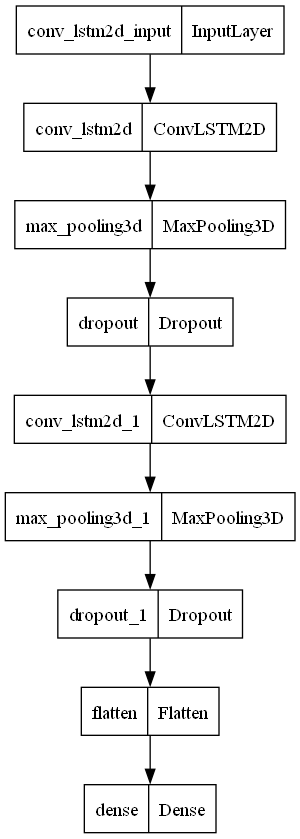

In [9]:
#plot the model
tf.keras.utils.plot_model(model)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 64, 128, 4)    1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 32, 64, 4)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 32, 64, 4)     0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 32, 64, 16)    11584     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 16, 32, 16)   0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 16, 32, 16)    0

In [11]:
#compile the model 
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [12]:
history = model.fit(x=X,y=Y,epochs=20)

Epoch 1/20
1/1 [==============================] - 28s 28s/step - loss: 1.0989 - accuracy: 0.2500
Epoch 2/20
1/1 [==============================] - 1s 902ms/step - loss: 11.6204 - accuracy: 0.3750
Epoch 3/20
1/1 [==============================] - 1s 859ms/step - loss: 13.9453 - accuracy: 0.3750
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 7.8293 - accuracy: 0.2500
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 3.5227 - accuracy: 0.3750
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 4.6688 - accuracy: 0.3750
Epoch 7/20
1/1 [==============================] - 1s 957ms/step - loss: 2.8896 - accuracy: 0.3750
Epoch 8/20
1/1 [==============================] - 1s 897ms/step - loss: 3.4337 - accuracy: 0.2500
Epoch 9/20
1/1 [==============================] - 1s 923ms/step - loss: 1.6868 - accuracy: 0.5000
Epoch 10/20
1/1 [==============================] - 1s 933ms/step - loss: 0.6133 - accuracy: 0.6250
Epoch 11/20
1/1 [==========

In [13]:
df=pd.DataFrame(history.history)
df

,loss,accuracy
0,1.098939,0.250
1,11.620375,0.375
2,13.945289,0.375
3,7.829349,0.250
4,3.522673,0.375
5,4.668842,0.375
6,2.889630,0.375
7,3.433702,0.250
8,1.686790,0.500
9,0.613326,0.625


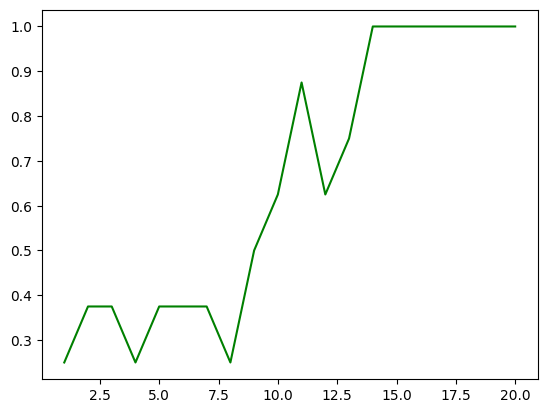

In [14]:
plt.plot(range(1,21),df.accuracy,color ='g')
plt.show()

In [6]:
model.evaluate(X,Y)

NameError: name 'model' is not defined

In [16]:
predicted = model.predict(X)
predicted


1/1 [==============================] - 1s 785ms/step


array([[0.8086236 , 0.10727714, 0.08409927],
       [0.8397417 , 0.12977524, 0.03048304],
       [0.06307425, 0.9195138 , 0.017412  ],
       [0.04645852, 0.743878  , 0.20966351],
       [0.10072398, 0.81724125, 0.08203471],
       [0.00410422, 0.00526875, 0.99062705],
       [0.01519734, 0.07775614, 0.9070465 ],
       [0.02022053, 0.01791979, 0.96185964]], dtype=float32)

In [17]:
classes = Y.columns.values
classes

array(['chandrma', 'dhakshin dhruv', 'viganik'], dtype=object)

In [18]:
for i in predicted:
    print(classes[np.argmax(i)])
    

chandrma
chandrma
dhakshin dhruv
dhakshin dhruv
dhakshin dhruv
viganik
viganik
viganik


In [19]:
#model.save("current model1")